In [35]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
random.seed(seed)

In [3]:
#Importing data
data = pd.read_excel('default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
#replace values 0, 5, 6 with 4 (others category) since they are not mentioned in the data description
data['EDUCATION'].replace([0,5,6],4,inplace=True)
data.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [5]:
#initial preprocessing: drop 'ID' column, rename target column to DEFAULT, rename PAY_0 to PAY_1 for consistency 
data.drop(columns='ID',inplace=True)
data.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)

In [6]:
#train test split (30%) before scaling and encoding to prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],test_size=0.3,stratify=data['DEFAULT'])

In [7]:
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
11018,160000,2,2,2,32,0,0,0,0,0,...,155404,153234,156731,155818,6000,6000,5600,6000,6000,5500
1710,100000,2,1,2,30,0,0,0,0,2,...,42283,51539,50583,52588,5000,10000,10000,0,2846,1936
4618,80000,1,1,2,29,0,0,0,0,0,...,64277,45455,42231,42804,3300,2500,1556,1600,1600,1600
5482,20000,2,2,1,27,0,0,-1,-1,-2,...,780,0,0,0,1006,780,0,0,0,0
26187,50000,2,1,2,30,-2,-2,-2,-2,-2,...,0,0,0,0,2070,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25780,200000,2,2,1,32,0,0,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
13921,120000,2,2,2,24,0,0,0,0,0,...,115515,113948,122127,121962,4200,4100,4100,10000,4560,0
3794,120000,2,1,2,24,0,0,0,0,0,...,67187,49924,33188,19826,3700,2023,2016,2000,1200,1000
27565,360000,1,1,1,57,1,-2,-1,-1,-1,...,860,246,-46,-46,0,860,246,0,0,0


In [8]:
#one hot encode categorical features and drop the first generated column to prevent multicollinearity
#first ohe train and save columns to apply to test set
X_train_encoded = pd.get_dummies(X_train, columns = ['EDUCATION','MARRIAGE'], drop_first = True)
cols_train = X_train_encoded.columns.tolist()

In [9]:
#ohe X_test and apply the same columns from X_train_encoded
X_test_encoded = pd.get_dummies(X_test,columns = ['EDUCATION','MARRIAGE'], drop_first = True)
X_test_encoded = X_test_encoded.reindex(columns = cols_train).fillna(0)   #if unknown columns assign 0

In [10]:
#numerical columns
numerical_cols = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [11]:
#Scaling numerical features
scaler = RobustScaler()

# Fit and transform the scaler on the training data
X_train_scaled_encoded = copy.deepcopy(X_train_encoded)
X_train_scaled_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform the test data using the fitted scaler
X_test_scaled_encoded = copy.deepcopy(X_test_encoded)
X_test_scaled_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

In [12]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)

In [13]:
X_train_SMOTE = copy.deepcopy(X_train_scaled_encoded)
y_train_SMOTE = copy.deepcopy(y_train)

In [14]:
X_train_SMOTE, y_train_SMOTE =  pipeline.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [15]:
X_train_SMOTE

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.789474,1,0.153846,0,0,0,0,0,0,2.087982,...,0.633848,0.131848,0.209414,0.362051,1,0,0,1,0,0
1,0.315789,2,0.153846,-1,-1,-1,-1,-1,-1,-0.310379,...,-0.282542,-0.395544,-0.226482,-0.384615,1,0,0,1,0,0
2,0.315789,1,-0.461538,0,0,0,0,0,0,3.117359,...,0.754988,2.768805,1.179413,1.410256,0,0,0,0,1,0
3,-0.684211,2,0.230769,0,-1,0,0,0,0,-0.192367,...,-0.195131,-0.263696,-0.264820,-0.256410,1,0,0,1,0,0
4,0.736842,2,-0.384615,0,0,0,0,0,0,1.999693,...,0.945012,1.160261,1.205672,1.179487,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19621,-0.631579,1,0.708271,0,0,0,0,0,0,-0.144369,...,-0.081657,-0.245543,-0.205891,-0.238786,1,0,0,1,0,0
19622,-0.610531,1,-0.400045,1,-2,-2,-2,-2,-2,-0.349716,...,-0.432660,-0.395544,-0.396114,-0.384615,1,0,0,1,0,0
19623,-0.191171,1,-0.538462,1,2,0,0,0,0,0.570358,...,0.057892,0.127288,0.216707,-0.109346,1,0,0,0,1,0
19624,-0.124371,2,0.014210,-1,2,2,-1,-1,0,-0.339591,...,-0.396786,-0.103777,-0.356455,-0.345890,0,0,0,1,0,0


In [16]:
temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
static_cols = ['LIMIT_BAL', 'SEX', 'AGE','EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']

In [17]:
X_train_temp = X_train_SMOTE[temp_cols]
X_train_static = X_train_SMOTE[static_cols]
X_test_temp = X_test_scaled_encoded[temp_cols]
X_test_static = X_test_scaled_encoded[static_cols]

In [18]:
#3 temporal features in reverse column order (April to September)
PAY = X_train_temp.iloc[:,5::-1]
BILL_AMT = X_train_temp.iloc[:,11:5:-1]
PAY_AMT = X_train_temp.iloc[:,:11:-1]

PAY = PAY.to_numpy()
BILL_AMT = BILL_AMT.to_numpy()
PAY_AMT = PAY_AMT.to_numpy()

#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked = np.dstack((PAY,BILL_AMT,PAY_AMT))

y_train_array = y_train_SMOTE.to_numpy()

In [19]:
#3 temporal features in reverse column order (April to September)
PAY_test = X_test_temp.iloc[:,5::-1]
BILL_AMT_test = X_test_temp.iloc[:,11:5:-1]
PAY_AMT_test = X_test_temp.iloc[:,:11:-1]

PAY_test = PAY_test.to_numpy()
BILL_AMT_test = BILL_AMT_test.to_numpy()
PAY_AMT_test = PAY_AMT_test.to_numpy()

#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked_test = np.dstack((PAY_test,BILL_AMT_test,PAY_AMT_test))

y_test_array = y_test.to_numpy()

In [20]:
num_time_steps, num_features = stacked.shape[1], stacked.shape[2]

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(num_time_steps, num_features)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 10
batch_size = 32

model.fit(stacked, y_train_array, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_array))

# Make predictions on the test set
y_pred_probs = model.predict(stacked_test)
y_pred = (y_pred_probs>=0.5).astype(int)

# Evaluate the model
loss, accuracy = model.evaluate(stacked_test, y_test_array)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/10
614/614 [==============================] - 6s 6ms/step - loss: 0.5457 - accuracy: 0.7444 - val_loss: 0.4726 - val_accuracy: 0.8068
Epoch 2/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5267 - accuracy: 0.7615 - val_loss: 0.4510 - val_accuracy: 0.8096
Epoch 3/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5215 - accuracy: 0.7648 - val_loss: 0.4659 - val_accuracy: 0.8063
Epoch 4/10
614/614 [==============================] - 3s 6ms/step - loss: 0.5194 - accuracy: 0.7643 - val_loss: 0.4755 - val_accuracy: 0.8056
Epoch 5/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5177 - accuracy: 0.7651 - val_loss: 0.4591 - val_accuracy: 0.8069
Epoch 6/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5165 - accuracy: 0.7643 - val_loss: 0.4592 - val_accuracy: 0.8079
Epoch 7/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5149 - accuracy: 0.7650 - val_loss: 0.4618 - val_accuracy: 0.8077
Epoch 

In [21]:
print('Accuracy:', accuracy_score(y_test_array,y_pred))
print('Precision:', precision_score(y_test_array,y_pred))
print('Recall:', recall_score(y_test_array,y_pred))
print('F1 score:', f1_score(y_test_array,y_pred))

Accuracy: 0.7978888888888889
Precision: 0.5464362850971922
Recall: 0.5082872928176796
F1 score: 0.526671870934166


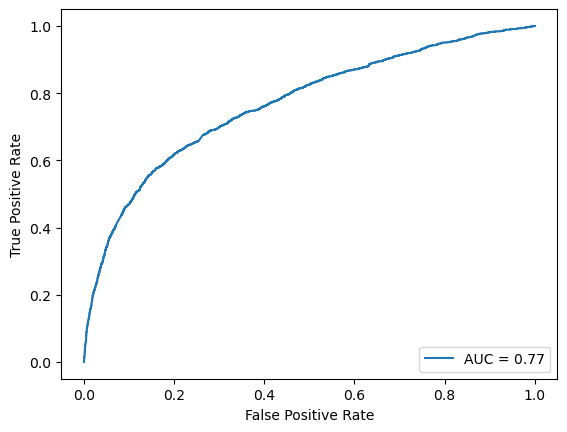

In [22]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_array, y_pred_probs)

# Calculate the AUC score
auc_score = roc_auc_score(y_test_array, y_pred_probs)

# Plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
roc_display.plot()
plt.show()

Reminder: only temporal features:
 
Accuracy: 0.8065555555555556

Precision: 0.5763125763125763

Recall: 0.4741336012054244

F1 score: 0.5202535133645633

In [23]:
# Get the output features from the LSTM layer
lstm_output = model.layers[0].output

# Create an input layer for the static features
static_input = Input(shape=(X_train_static.shape[1],))  # Assuming num_static_features is the number of static features in X_train_static

# Concatenate the LSTM output with the static input
concatenated_output = Concatenate()([lstm_output, static_input])

# Add a dense layer with one neuron after the concatenation
output = Dense(1, activation='sigmoid')(concatenated_output)

# Create the final model with the concatenated input and the dense layer
final_model = Model(inputs=[model.input, static_input], outputs=output)

# Compile the final model
final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the final model
epochs = 10
batch_size = 32

final_model.fit([stacked, X_train_static], y_train_array, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_static], y_test_array))

# Make predictions on the test set
y_pred_probs2 = final_model.predict([stacked_test, X_test_static])
y_pred2 = (y_pred_probs2 >= 0.5).astype(int)

# Evaluate the final model
loss2, accuracy2 = final_model.evaluate([stacked_test, X_test_static], y_test_array)
print(f'Test Loss: {loss2:.4f}')
print(f'Test Accuracy: {accuracy2:.4f}')

Epoch 1/10
614/614 [==============================] - 6s 6ms/step - loss: 0.5263 - accuracy: 0.7572 - val_loss: 0.4611 - val_accuracy: 0.8071
Epoch 2/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5094 - accuracy: 0.7673 - val_loss: 0.4651 - val_accuracy: 0.8008
Epoch 3/10
614/614 [==============================] - 3s 5ms/step - loss: 0.5061 - accuracy: 0.7693 - val_loss: 0.4512 - val_accuracy: 0.8089
Epoch 4/10
614/614 [==============================] - 3s 6ms/step - loss: 0.5036 - accuracy: 0.7699 - val_loss: 0.4543 - val_accuracy: 0.8083
Epoch 5/10
614/614 [==============================] - 4s 6ms/step - loss: 0.5020 - accuracy: 0.7715 - val_loss: 0.4588 - val_accuracy: 0.8012
Epoch 6/10
614/614 [==============================] - 3s 6ms/step - loss: 0.5003 - accuracy: 0.7716 - val_loss: 0.4590 - val_accuracy: 0.8024
Epoch 7/10
614/614 [==============================] - 3s 6ms/step - loss: 0.4987 - accuracy: 0.7723 - val_loss: 0.4633 - val_accuracy: 0.8029
Epoch 

In [24]:
print('Accuracy:', accuracy_score(y_test_array,y_pred2))
print('Precision:', precision_score(y_test_array,y_pred2))
print('Recall:', recall_score(y_test_array,y_pred2))
print('F1 score:', f1_score(y_test_array,y_pred2))

Accuracy: 0.8013333333333333
Precision: 0.557703240477544
Recall: 0.4927172275238574
F1 score: 0.5232


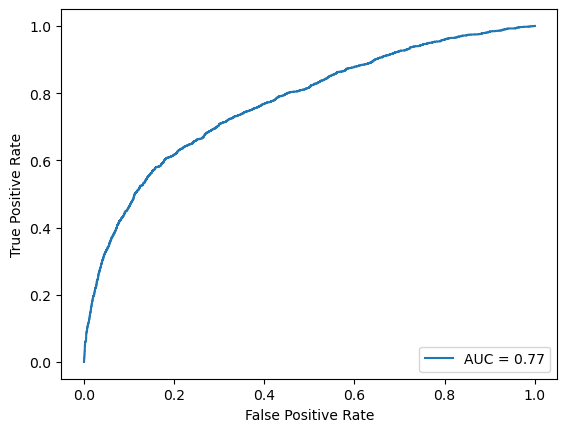

In [25]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr2, tpr2, thresholds2 = roc_curve(y_test_array, y_pred_probs2)

# Calculate the AUC score
auc_score2 = roc_auc_score(y_test_array, y_pred_probs2)

# Plot the ROC curve
roc_display2 = RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=auc_score2)
roc_display2.plot()
plt.show()

In [26]:
#x test
features_layer1 = Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=0).output,
)

inter_test = features_layer1.predict(stacked_test)

282/282 [==============================] - 1s 2ms/step


In [28]:
#x train
features_layer2 = Model(
    inputs=model.inputs,
    outputs=model.get_layer(index=0).output,
)

inter_train = features_layer1.predict(stacked)

614/614 [==============================] - 1s 2ms/step


In [29]:
import xgboost as xgb

In [30]:
#ARXIKO INPUT

# Train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the validation set
y_pred3 = xgb_model.predict(X_test_scaled_encoded)

print('Accuracy:', accuracy_score(y_test,y_pred3))
print('Precision:', precision_score(y_test,y_pred3))
print('Recall:', recall_score(y_test,y_pred3))
print('F1 score:', f1_score(y_test,y_pred3))


Accuracy: 0.8018888888888889
Precision: 0.56951871657754
Recall: 0.42792566549472627
F1 score: 0.48867221106968745


In [31]:
#INPUT AFTER LSTM

# Train an XGBoost model
xgb_model2 = xgb.XGBClassifier()
xgb_model2.fit(inter_train, y_train_array)

# Make predictions on the validation set
y_pred4 = xgb_model2.predict(inter_test)

print('Accuracy:', accuracy_score(y_test_array,y_pred4))
print('Precision:', precision_score(y_test_array,y_pred4))
print('Recall:', recall_score(y_test_array,y_pred4))
print('F1 score:', f1_score(y_test_array,y_pred4))

Accuracy: 0.7894444444444444
Precision: 0.5278099652375434
Recall: 0.4575590155700653
F1 score: 0.4901802528921173


In [32]:
from sklearn.ensemble import RandomForestClassifier
#ARXIKO INPUT

# Train an RF model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_SMOTE, y_train_SMOTE)

# Make predictions on the validation set
y_pred5 = rf_model.predict(X_test_scaled_encoded)

print('Accuracy:', accuracy_score(y_test,y_pred5))
print('Precision:', precision_score(y_test,y_pred5))
print('Recall:', recall_score(y_test,y_pred5))
print('F1 score:', f1_score(y_test,y_pred5))


Accuracy: 0.8061111111111111
Precision: 0.5814569536423841
Recall: 0.44098442993470616
F1 score: 0.50157097972008


In [33]:
#INPUT AFTER LSTM

# Train an RF model
rf_model2 = RandomForestClassifier()
rf_model2.fit(inter_train, y_train_array)

# Make predictions on the validation set
y_pred6 = rf_model2.predict(inter_test)

print('Accuracy:', accuracy_score(y_test_array,y_pred6))
print('Precision:', precision_score(y_test_array,y_pred6))
print('Recall:', recall_score(y_test_array,y_pred6))
print('F1 score:', f1_score(y_test_array,y_pred6))

Accuracy: 0.7857777777777778
Precision: 0.5178066704352742
Recall: 0.4600703164239076
F1 score: 0.4872340425531915


In [36]:
num_time_steps, num_features = stacked.shape[1], stacked.shape[2]

# Define the LSTM model_new
model_new = Sequential()
model_new.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_time_steps, num_features)))
model_new.add(MaxPooling1D(pool_size=2))
model_new.add(Flatten())
model_new.add(Dense(1, activation='sigmoid'))

# Compile the model_new
model_new.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model_new
epochs = 10
batch_size = 32

model_new.fit(stacked, y_train_array, epochs=epochs, batch_size=batch_size, validation_data=(stacked_test, y_test_array))

# Make predictions on the test set
y_pred_probs9 = model_new.predict(stacked_test)
y_pred9 = (y_pred_probs9>=0.5).astype(int)

# Evaluate the model_new
loss9, accuracy9 = model_new.evaluate(stacked_test, y_test_array)
print(f'Test Loss: {loss9:.4f}')
print(f'Test Accuracy: {accuracy9:.4f}')

Epoch 1/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5804 - accuracy: 0.7344 - val_loss: 0.4869 - val_accuracy: 0.8012
Epoch 2/10
614/614 [==============================] - 2s 2ms/step - loss: 0.5365 - accuracy: 0.7599 - val_loss: 0.4925 - val_accuracy: 0.7947
Epoch 3/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5314 - accuracy: 0.7614 - val_loss: 0.4717 - val_accuracy: 0.8048
Epoch 4/10
614/614 [==============================] - 6s 10ms/step - loss: 0.5294 - accuracy: 0.7626 - val_loss: 0.4721 - val_accuracy: 0.8047
Epoch 5/10
614/614 [==============================] - 2s 4ms/step - loss: 0.5266 - accuracy: 0.7620 - val_loss: 0.4648 - val_accuracy: 0.8064
Epoch 6/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5271 - accuracy: 0.7633 - val_loss: 0.4766 - val_accuracy: 0.8053
Epoch 7/10
614/614 [==============================] - 1s 2ms/step - loss: 0.5258 - accuracy: 0.7632 - val_loss: 0.4691 - val_accuracy: 0.8048
Epoch

In [37]:
print('Accuracy:', accuracy_score(y_test_array,y_pred9))
print('Precision:', precision_score(y_test_array,y_pred9))
print('Recall:', recall_score(y_test_array,y_pred9))
print('F1 score:', f1_score(y_test_array,y_pred9))

Accuracy: 0.8048888888888889
Precision: 0.5774555042847725
Recall: 0.43997990959316924
F1 score: 0.49942987457240595


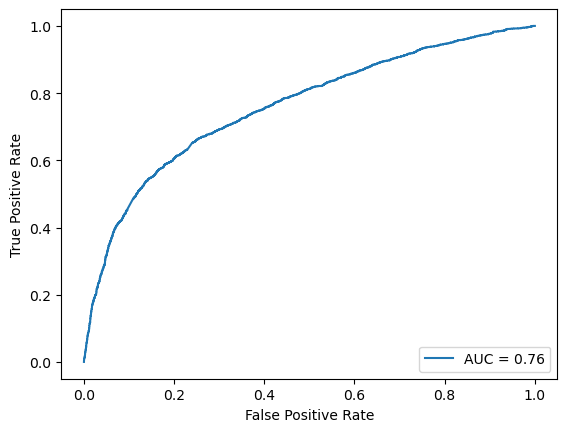

In [38]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr9, tpr9, thresholds9 = roc_curve(y_test_array, y_pred_probs9)

# Calculate the AUC score
auc_score9 = roc_auc_score(y_test_array, y_pred_probs9)

# Plot the ROC curve
roc_display9 = RocCurveDisplay(fpr=fpr9, tpr=tpr9, roc_auc=auc_score9)
roc_display9.plot()
plt.show()

In [39]:
# Define the CNN model for feature extraction
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_time_steps, num_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())

# Define the input shape for the static features
static_input_cnn = Input(shape=(X_train_static.shape[1],))

# Concatenate the output from the CNN and the static input
concatenated_output_cnn = Concatenate()([cnn_model.output, static_input_cnn])

# Add a dense layer with one neuron after the concatenation
output_cnn = Dense(1, activation='sigmoid')(concatenated_output_cnn)

# Create the final model with the concatenated input and the dense layer
final_model_cnn = Model(inputs=[cnn_model.input, static_input_cnn], outputs=output_cnn)

# Compile the final model
final_model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the final model
epochs = 10
batch_size = 32

final_model_cnn.fit([stacked, X_train_static], y_train_array, epochs=epochs, batch_size=batch_size, validation_data=([stacked_test, X_test_static], y_test_array))

# Make predictions on the test set
y_pred_probs10 = final_model_cnn.predict([stacked_test, X_test_static])
y_pred10 = (y_pred_probs10 >= 0.5).astype(int)

# Evaluate the final model
loss10, accuracy10 = final_model_cnn.evaluate([stacked_test, X_test_static], y_test_array)
print(f'Test Loss: {loss10:.4f}')
print(f'Test Accuracy: {accuracy10:.4f}')

Epoch 1/10
614/614 [==============================] - 3s 4ms/step - loss: 0.5501 - accuracy: 0.7413 - val_loss: 0.4803 - val_accuracy: 0.7984
Epoch 2/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5293 - accuracy: 0.7570 - val_loss: 0.4751 - val_accuracy: 0.8044
Epoch 3/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5244 - accuracy: 0.7616 - val_loss: 0.4681 - val_accuracy: 0.8046
Epoch 4/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5212 - accuracy: 0.7618 - val_loss: 0.4696 - val_accuracy: 0.8039
Epoch 5/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5192 - accuracy: 0.7643 - val_loss: 0.4681 - val_accuracy: 0.8038
Epoch 6/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5183 - accuracy: 0.7645 - val_loss: 0.4689 - val_accuracy: 0.8041
Epoch 7/10
614/614 [==============================] - 2s 3ms/step - loss: 0.5169 - accuracy: 0.7649 - val_loss: 0.4774 - val_accuracy: 0.8007
Epoch 

In [40]:
print('Accuracy:', accuracy_score(y_test_array,y_pred10))
print('Precision:', precision_score(y_test_array,y_pred10))
print('Recall:', recall_score(y_test_array,y_pred10))
print('F1 score:', f1_score(y_test_array,y_pred10))

Accuracy: 0.8067777777777778
Precision: 0.5847913862718708
Recall: 0.43646408839779005
F1 score: 0.49985619787172847


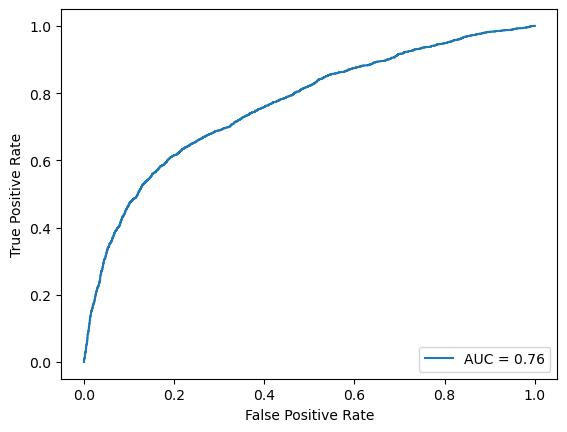

In [41]:
# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr10, tpr10, thresholds10 = roc_curve(y_test_array, y_pred_probs10)

# Calculate the AUC score
auc_score10 = roc_auc_score(y_test_array, y_pred_probs10)

# Plot the ROC curve
roc_display10 = RocCurveDisplay(fpr=fpr10, tpr=tpr10, roc_auc=auc_score10)
roc_display10.plot()
plt.show()